# Exact GP Regression on Classification Labels

For dataset size < 10,000, ExactGP works fine.

"In GPyTorch, Exact GP inference is still our preferred approach to large regression datasets. By coupling GPU acceleration with BlackBox Matrix-Matrix Inference and LancZos Variance Estimates (LOVE), GPyTorch can perform inference on datasets with over 1,000,000 data points while making very few approximations."
--[GPyTorch docs](https://docs.gpytorch.ai/en/stable/examples/02_Scalable_Exact_GPs/index.html)

Paper: https://proceedings.neurips.cc/paper_files/paper/2018/file/b6617980ce90f637e68c3ebe8b9be745-Paper.pdf


In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


# check version number
import imblearn
print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler

import random
random.seed(2024)

imblearn version:  0.11.0


In [2]:
# confusion matrix
import sklearn
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
# from sklearn 0.19.2 documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# Get training data
uq_path = "/p/lustre2/fan4/myGPyTorch/classification_NEK2/data/"
train_x_df_temp = pd.read_csv(uq_path+"/NEK2_1_uM_min_50_pct_binding_random_fold1_trainX.csv")
train_y_df_temp = pd.read_csv(uq_path+"/NEK2_1_uM_min_50_pct_binding_random_fold1_trainY.csv")
test_x_df = pd.read_csv(uq_path+"/NEK2_1_uM_min_50_pct_binding_random_fold1_testX.csv")
test_y_df = pd.read_csv(uq_path+"/NEK2_1_uM_min_50_pct_binding_random_fold1_testY.csv")



In [39]:
test_y_df

,active
0,0
1,0
2,0
3,0
4,0
...,...
277,0
278,0
279,0
280,0


In [36]:
# SMOTE: Adjust imbalanced training data

# transform the dataset
oversample = SMOTE()
new_train_x_df, new_train_y_df = oversample.fit_resample(train_x_df_temp, train_y_df_temp)

display(new_train_x_df.head)

display("original training size: ",train_x_df_temp.shape)
display(train_y_df_temp.value_counts())
display("SMOTE train set size:",new_train_x_df.shape)
display(new_train_y_df.value_counts())

<bound method NDFrame.head of       ASA+_per_atom        ASA-  ASA_H_per_atom       ASA_P  ASA_per_atom  \
0         14.897949   53.326256        8.903966  161.217960     17.860519   
1          6.511466  299.143010        8.385662  196.062190     11.950429   
2          8.496225  275.100830        8.517174  278.048280     13.229856   
3          6.791036  344.713500        8.136228  261.311580     12.350931   
4          9.173611  133.466250        9.677048  114.335650     12.685881   
...             ...         ...             ...         ...           ...   
2149       9.380343  134.355426        8.745999  176.600664     11.428777   
2150       8.945779  174.366322       10.178379  130.002073     13.790027   
2151       6.651470  245.517514        8.222005  128.821067      9.946793   
2152       8.920849  188.150399       10.056409  144.062843     12.937666   
2153       8.069262  224.811221        8.264181  219.605685     12.121243   

      BCUT_PEOE_0  BCUT_PEOE_1  BCUT_PEOE_2  

'original training size: '

(1126, 306)

active
0         1077
1           49
Name: count, dtype: int64

'SMOTE train set size:'

(2154, 306)

active
0         1077
1         1077
Name: count, dtype: int64

In [5]:
train_x_df = new_train_x_df
train_y_df = new_train_y_df

train_x_df.to_csv(uq_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_trainX.csv", index=False)
train_y_df.to_csv(uq_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_trainY.csv", index=False)
test_x_df.to_csv(uq_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_testX.csv", index=False)
test_y_df.to_csv(uq_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_testY.csv", index=False)


In [38]:
test_y_df

,active
0,0
1,0
2,0
3,0
4,0
...,...
277,0
278,0
279,0
280,0


In [6]:
# Transform data to PyTorch tensors

# Scale data
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_scaled_data = scaling.transform(train_x_df)
test_scaled_data = scaling.transform(test_x_df) 


train_x_temp = train_scaled_data.astype("long")
test_x_temp = test_scaled_data.astype("long")

train_y_temp = train_y_df.to_numpy().flatten().astype("long")
test_y_temp = test_y_df.to_numpy().flatten().astype("long")


train_x = torch.from_numpy(train_x_temp)
train_y = torch.from_numpy(train_y_temp)
test_x = torch.from_numpy(test_x_temp)
test_y = torch.from_numpy(test_y_temp)


print(train_x.shape)
print(train_y.shape)

torch.Size([2154, 306])
torch.Size([2154])


In [7]:
# Construct a GP classification model

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)


In [8]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 300


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/300 - Loss: 7.042   lengthscale: 0.693   noise: 0.693
Iter 6/300 - Loss: 6.307   lengthscale: 0.974   noise: 0.972
Iter 11/300 - Loss: 5.763   lengthscale: 1.317   noise: 1.288
Iter 16/300 - Loss: 5.354   lengthscale: 1.725   noise: 1.596
Iter 21/300 - Loss: 5.043   lengthscale: 2.199   noise: 1.832
Iter 26/300 - Loss: 4.805   lengthscale: 2.725   noise: 1.945
Iter 31/300 - Loss: 4.617   lengthscale: 3.272   noise: 1.920
Iter 36/300 - Loss: 4.456   lengthscale: 3.813   noise: 1.770
Iter 41/300 - Loss: 4.291   lengthscale: 4.338   noise: 1.523
Iter 46/300 - Loss: 4.146   lengthscale: 4.840   noise: 1.218
Iter 51/300 - Loss: 4.004   lengthscale: 5.302   noise: 0.905
Iter 56/300 - Loss: 3.890   lengthscale: 5.713   noise: 0.628
Iter 61/300 - Loss: 3.796   lengthscale: 6.067   noise: 0.414
Iter 66/300 - Loss: 3.727   lengthscale: 6.367   noise: 0.269
Iter 71/300 - Loss: 3.672   lengthscale: 6.618   noise: 0.179
Iter 76/300 - Loss: 3.635   lengthscale: 6.825   noise: 0.125
Iter 81/30

In [47]:
# Make predictions with the model

model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    train_dist = model(train_x)
    pred_means = train_dist.loc
    observed_pred = likelihood(model(train_x))
    
print(pred_means.numpy().shape)
print(pred_means.max(0)[1])
print(observed_pred.loc.max(0)[1])

(2, 2154)
tensor([0, 0, 0,  ..., 1, 1, 1])
tensor([0, 0, 0,  ..., 1, 1, 1])


Confusion matrix, without normalization
[[1076    1]
 [   0 1077]]


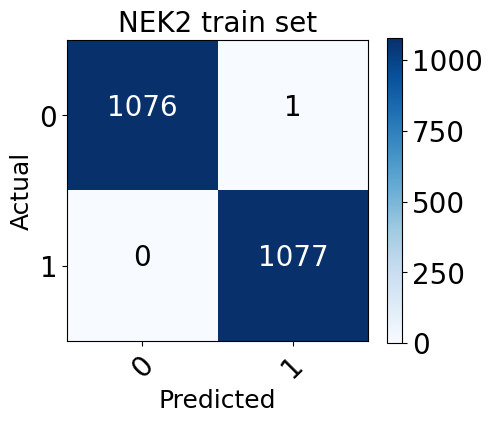

In [10]:
train_prediction = model(train_x).loc.max(0)[1].numpy()
y_true = train_y_df.values
y_pred = train_prediction
train_cm = confusion_matrix(y_true, y_pred)
class_names = ["0","1"]

plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 train set",fontsize=20)
plot_confusion_matrix(train_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


In [11]:
# Make predictions with the model
# Prediction on the test set

model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)
    test_pred_means = test_dist.loc
    test_pred = likelihood(model(test_x))
    
print(test_pred_means.numpy().shape)
print(test_pred_means.max(0)[1])

(2, 282)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [12]:
test_prediction = model(test_x).loc.max(0)[1].numpy()
print(test_prediction.shape)
test_prediction

(282,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Confusion matrix, without normalization
[[268   6]
 [  4   4]]


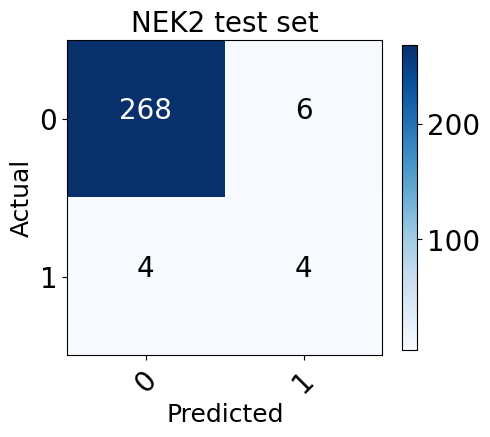

In [25]:
y_true = test_y_df.values.flatten()
y_pred = test_prediction
test_cm = confusion_matrix(y_true, y_pred)
class_names = ["0","1"]

plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 test set",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


In [14]:
test_pred.mean.numpy()

array([[-5.40790796e-01, -1.26779532e+00, -4.24444109e-01,
         2.52899855e-01, -1.63721383e-01, -1.57081872e-01,
        -1.19188586e-02, -1.35534549e+00, -4.27861005e-01,
        -1.31680846e+00, -6.09024286e-01, -2.13510066e-01,
        -5.10277271e-01, -3.27175170e-01, -2.68979478e+00,
        -2.69128114e-01,  1.90694541e-01, -4.26611692e-01,
        -1.87510282e-01,  7.87803903e-02, -2.02844411e-01,
        -2.73397237e-01, -2.84786016e-01, -4.79076654e-01,
        -7.28529811e-01,  7.64723122e-03, -1.99858457e-01,
        -6.42232180e-01, -7.67134190e-01, -3.79941732e-01,
        -5.52580357e-01, -2.31870151e+00,  1.16532065e-01,
        -5.00518560e-01, -3.30710590e-01, -3.94668132e-01,
        -5.24156809e-01, -1.26082540e+00, -6.15972996e-01,
         4.84102145e-02, -3.72696191e-01, -1.20419385e-02,
        -3.92983228e-01, -1.87379390e-01, -1.09185785e-01,
        -2.71222234e+00, -1.52498037e-01, -2.06299812e-01,
        -2.09985614e+00, -1.84958434e+00, -1.02415538e+0

In [15]:
print(test_pred.variance.numpy().shape)
test_pred.variance.numpy()
test_pred_variance2D = test_pred.variance.numpy()
test_pred_variance2D

(2, 282)


array([[2.0923839, 2.0143576, 2.1476965, 2.0170228, 2.184648 , 1.5238292,
        2.1912131, 1.7874923, 1.3537745, 1.9510674, 1.8957976, 2.061437 ,
        2.10155  , 2.1210446, 1.9893109, 1.1858175, 2.0859792, 1.5562218,
        2.0390394, 1.4767661, 2.0202048, 1.6845052, 1.7079408, 2.0691528,
        2.1113348, 2.1895304, 1.8960462, 2.067964 , 2.0677462, 2.1737363,
        2.0979438, 1.7171837, 2.1352832, 1.8260261, 2.1819847, 2.1086922,
        2.008689 , 1.7900023, 2.1068268, 2.1751683, 2.0464501, 2.1912131,
        1.8849124, 2.0121105, 2.1858609, 1.9964879, 1.8951359, 2.1472173,
        1.5992091, 1.1520526, 1.3848615, 2.181257 , 1.9466801, 1.9830948,
        2.1608179, 2.1071177, 1.9647298, 2.1883264, 2.0572119, 1.4008801,
        1.944543 , 2.0535488, 2.1444726, 1.5075877, 1.725352 , 2.1330214,
        2.1911175, 2.1378832, 1.6322459, 2.165606 , 1.8445356, 1.7318783,
        1.6695877, 1.5533571, 1.9510032, 1.6199961, 2.158077 , 0.9171623,
        2.0684223, 2.1062407, 2.162322

In [16]:
var_min = test_pred_variance2D.min(axis=0).min()
var_max = test_pred_variance2D.max(axis=0).max()
print(var_min, var_max)

0.8433819 3.3811092


In [17]:
# Training set variance
print(observed_pred.variance.numpy().shape)
observed_pred.variance.numpy()

(2, 2154)


array([[2.866344 , 2.3773403, 2.5463696, ..., 5.4737186, 5.135954 ,
        5.027563 ],
       [7.969572 , 6.426771 , 6.730214 , ..., 1.4338092, 1.192115 ,
        1.103175 ]], dtype=float32)

In [18]:
# Using test prediction as index to extract prediction variance
test_pred_variance = [test_pred_variance2D[value][idx] for idx,value in enumerate(test_prediction)]
test_pred_variance


[2.0923839,
 2.0143576,
 2.1476965,
 2.0170228,
 2.184648,
 1.5238292,
 2.1912131,
 1.7874923,
 1.3537745,
 1.9510674,
 1.8957976,
 2.061437,
 2.10155,
 2.1210446,
 1.9893109,
 1.1858175,
 2.0859792,
 1.5562218,
 2.0390394,
 1.4767661,
 2.0202048,
 1.6845052,
 1.7079408,
 2.0691528,
 2.1113348,
 2.1895304,
 1.8960462,
 2.067964,
 2.0677462,
 2.1737363,
 2.0979438,
 1.7171837,
 2.1352832,
 1.8260261,
 2.1819847,
 2.1086922,
 2.008689,
 1.7900023,
 2.1068268,
 2.1751683,
 2.0464501,
 2.1912131,
 1.8849124,
 2.0121105,
 2.1858609,
 1.9964879,
 1.8951359,
 2.1472173,
 1.5992091,
 1.1520526,
 1.3848615,
 2.181257,
 1.9466801,
 1.9830948,
 2.1608179,
 2.1071177,
 1.9647298,
 2.1883264,
 2.0572119,
 1.4008801,
 1.944543,
 2.0535488,
 2.1444726,
 1.5725846,
 1.725352,
 2.1330214,
 2.1911175,
 2.1378832,
 1.6322459,
 2.165606,
 1.8445356,
 1.7318783,
 1.6695877,
 1.5533571,
 1.9510032,
 1.6199961,
 2.158077,
 0.8750274,
 2.0684223,
 2.1062407,
 2.162322,
 2.1909049,
 1.7346487,
 2.0341198,
 1.8

In [26]:
display(np.arange(len(y_true)).shape)
display((y_true - test_prediction).shape)
display(y_true.shape)
display(test_prediction.shape)

(282,)

(282,)

(282,)

(282,)

/tmp/ipykernel_2503442/4124740066.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


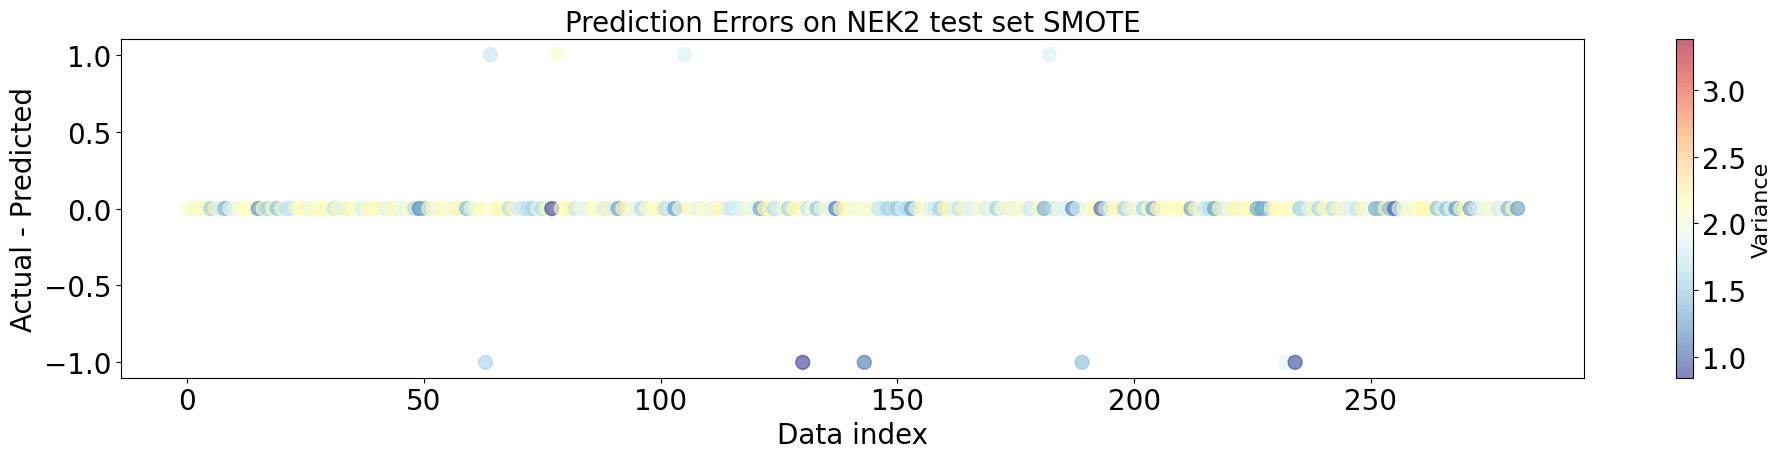

In [27]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(y_true)),(y_true - test_prediction), c=test_pred_variance, s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

/tmp/ipykernel_2503442/511522001.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


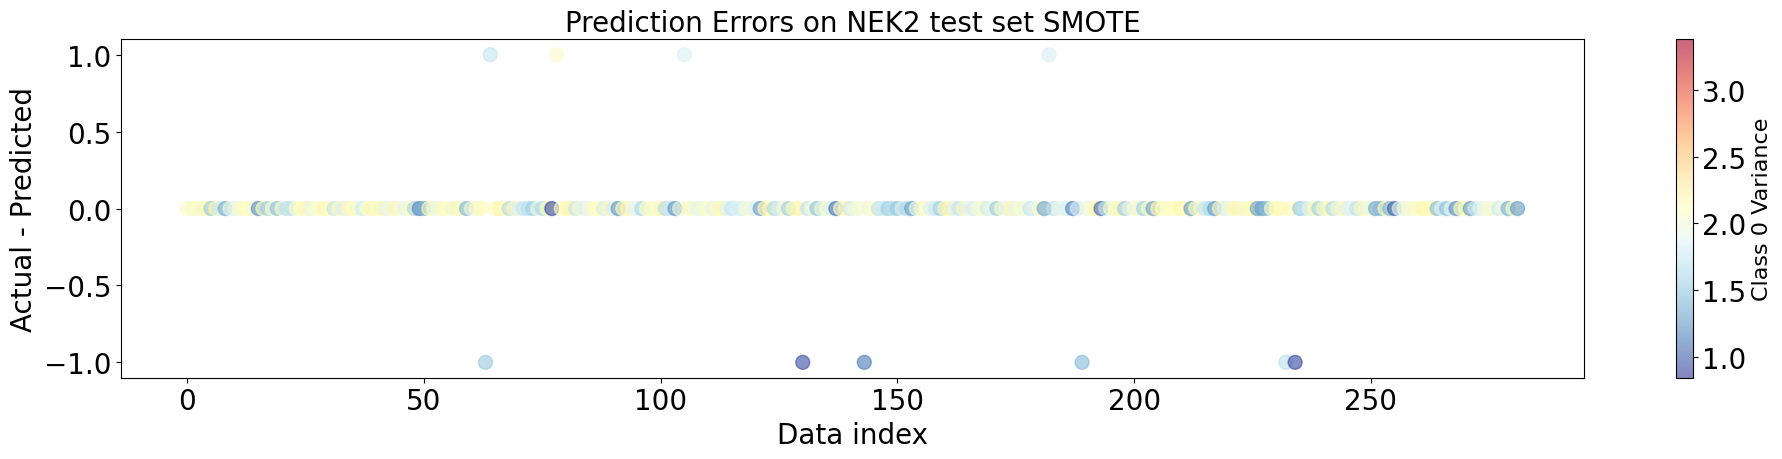

In [28]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(y_true)),(y_true - test_prediction), c=test_pred_variance2D[0], s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Class 0 Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

/tmp/ipykernel_2503442/2618591066.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


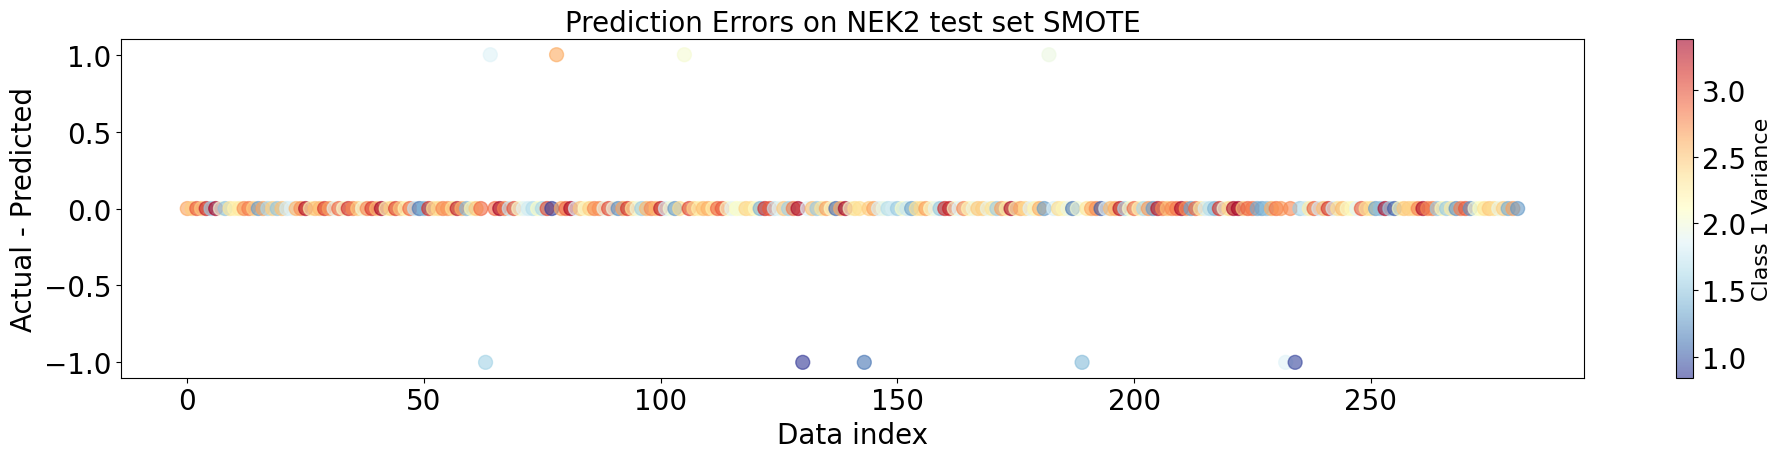

In [29]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(y_true)),(y_true - test_prediction), c=test_pred_variance2D[1], s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Class 1 Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

In [30]:
lower, upper = test_pred.confidence_region()
upper

tensor([[ 2.3522,  1.5708,  2.5066,  3.0933,  2.7924,  2.3118,  2.9486,  1.3186,
          1.8992,  1.4768,  2.1447,  2.6580,  2.3891,  2.5856,  0.1311,  1.9088,
          3.0793,  2.0684,  2.6684,  2.5092,  2.6398,  2.3224,  2.3290,  2.3978,
          2.1776,  2.9671,  2.5541,  2.2339,  2.1088,  2.5688,  2.3443,  0.3021,
          3.0391,  2.2021,  2.6236,  2.5096,  2.3104,  1.4150,  2.2870,  2.9981,
          2.4884,  2.9485,  2.3529,  2.6496,  2.8477,  0.1137,  2.6008,  2.7244,
          0.4293,  0.2971,  1.3294,  2.7768,  1.5750,  2.7478,  2.6964,  2.5601,
          2.7561,  2.8763,  2.2029, -0.3055,  2.7380,  2.6163,  2.4671, -0.5611,
          0.7388,  2.8801,  2.9377,  2.6611,  1.9680,  2.7342,  1.2654,  2.5040,
          2.6513,  0.9257,  2.2806,  2.1999,  2.5510, -3.9027,  2.5497,  2.6116,
          2.8026,  2.9603,  0.1314,  2.5263,  1.1222,  1.9467,  1.9108,  2.1259,
          1.8195,  2.5667,  2.7069, -0.3526,  2.4603,  2.6192,  0.8833,  1.9347,
          2.1987,  2.6723,  

## Probabilities
Unfortunately, we can’t get closed form estimates of the probabilities; however, we can approximate them with a lightweight sampling step using $J$ samples from the posterior as:


$\displaystyle\mathbb{E}(p(y_i=j)) = \int \frac{\exp\{f_i^*\}}{\sum_k^C\exp\{f_i^*\}}p(f^*\|y)df^* \approx \frac{1}{J}\sum_j^J\frac{\exp\{f_{i,j}^*\}}{\sum_k^C\exp\{f_{i,j}^*\}}$. 

Here, we draw __256__ samples from the posterior.

In [33]:
# Compute probability for the test set
# Draw samples from the posterior.
pred_samples = test_dist.sample(torch.Size((100,))).exp()
pred_samples.shape

torch.Size([100, 2, 282])

In [35]:
display(pred_samples)

tensor([[[1.7128e-01, 1.1011e-01, 5.7993e-01,  ..., 1.0249e+00,
          1.9401e+00, 7.6366e-02],
         [9.1815e-04, 2.9766e-03, 3.3124e-03,  ..., 2.6865e-03,
          1.3595e-03, 7.0829e-03]],

        [[1.5529e+00, 6.6846e-02, 1.0634e-01,  ..., 2.8272e-01,
          2.7676e+00, 2.6644e-01],
         [2.8347e-05, 1.0825e-04, 7.8511e-04,  ..., 2.8225e-03,
          2.1975e-04, 3.4101e-02]],

        [[4.7841e-02, 8.3465e-01, 4.8265e-01,  ..., 2.2941e-01,
          1.6318e-01, 1.9666e+00],
         [7.1465e-04, 3.3248e-03, 6.1444e-03,  ..., 3.4657e-04,
          6.6127e-05, 1.2144e-02]],

        ...,

        [[1.2701e+00, 2.5976e-02, 9.1554e-02,  ..., 4.0501e-02,
          1.5941e+00, 2.4066e-02],
         [2.9552e-03, 1.5497e-02, 3.4495e-04,  ..., 1.6722e-02,
          1.7961e-03, 1.0848e-02]],

        [[9.0551e-02, 6.5522e-02, 1.6790e+00,  ..., 2.1027e-01,
          5.2709e+00, 3.1229e-02],
         [6.9476e-04, 8.8936e-02, 1.0820e-02,  ..., 2.2152e-03,
          7.2134e-03, 7

In [37]:
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
probabilities[0,]

tensor([0.9875, 0.9017, 0.9788, 0.9987, 0.9844, 0.9911, 0.9882, 0.9062, 0.9931,
        0.8778, 0.9736, 0.9936, 0.9811, 0.9886, 0.5698, 0.9970, 0.9956, 0.9890,
        0.9870, 0.9962, 0.9815, 0.9860, 0.9929, 0.9830, 0.9709, 0.9923, 0.9958,
        0.9755, 0.9636, 0.9840, 0.9687, 0.7181, 0.9885, 0.9851, 0.9839, 0.9758,
        0.9698, 0.8984, 0.9789, 0.9954, 0.9882, 0.9920, 0.9815, 0.9909, 0.9946,
        0.4951, 0.9813, 0.9895, 0.7241, 0.8824, 0.9404, 0.9848, 0.9123, 0.9870,
        0.9864, 0.9834, 0.9896, 0.9893, 0.9589, 0.6918, 0.9920, 0.9830, 0.9825,
        0.4823, 0.8483, 0.9917, 0.9909, 0.9943, 0.9724, 0.9912, 0.9084, 0.9788,
        0.9955, 0.8831, 0.9899, 0.9916, 0.9763, 0.0122, 0.9927, 0.9822, 0.9927,
        0.9906, 0.6093, 0.9868, 0.8659, 0.9309, 0.9441, 0.9584, 0.9578, 0.9721,
        0.9970, 0.6317, 0.9499, 0.9692, 0.8594, 0.9742, 0.9881, 0.9783, 0.9892,
        0.9621, 0.9785, 0.7140, 0.9947, 0.9087, 0.9689, 0.8894, 0.9975, 0.9075,
        0.9589, 0.9814, 0.9917, 0.8096, 

In [42]:
# Compute probability for the train set
# Draw samples from the posterior.
train_pred_samples = train_dist.sample(torch.Size((256,))).exp()
train_probabilities = (train_pred_samples / train_pred_samples.sum(-2, keepdim=True)).mean(0)
train_probabilities.shape

torch.Size([2, 2154])

## Save model performance to file

In [45]:
train_perf_df = pd.DataFrame()
test_perf_df = pd.DataFrame()

train_perf_df["mean_pred_class0"] = observed_pred.mean.numpy()[0,]
train_perf_df["mean_pred_class1"] = observed_pred.mean.numpy()[1,]
train_perf_df["y"] = train_y
train_perf_df["y_pred"] = pred_means.max(0)[1]
train_perf_df["var_pred_class0"] = observed_pred.variance.numpy()[0,]
train_perf_df["var_pred_class1"] = observed_pred.variance.numpy()[1,]
train_perf_df['pred_probability_class0'] = train_probabilities.numpy()[0,]
train_perf_df['pred_probability_class1'] = train_probabilities.numpy()[1,]

test_perf_df["mean_pred_class0"] = test_pred.mean.numpy()[0,]
test_perf_df["mean_pred_class1"] = test_pred.mean.numpy()[1,]
test_perf_df["y"] = test_y
test_perf_df["y_pred"] = test_pred_means.max(0)[1]
test_perf_df["var_pred_class0"] = test_pred.variance.numpy()[0,]
test_perf_df["var_pred_class1"] = test_pred.variance.numpy()[1,]
test_perf_df['pred_probability_class0'] = probabilities.numpy()[0,]
test_perf_df['pred_probability_class1'] = probabilities.numpy()[1,]

test_perf_df

,mean_pred_class0,mean_pred_class1,y,y_pred,var_pred_class0,var_pred_class1,pred_probability_class0,pred_probability_class1
0,-0.540791,-6.379445,0,0,2.092384,2.658002,0.987508,0.012492
1,-1.267795,-5.061481,0,0,2.014358,2.452380,0.901677,0.098323
2,-0.424444,-6.141542,0,0,2.147696,2.966817,0.978806,0.021194
3,0.252900,-7.770184,0,0,2.017023,2.471880,0.998679,0.001321
4,-0.163721,-6.569057,0,0,2.184648,3.217909,0.984373,0.015627
...,...,...,...,...,...,...,...,...
277,-0.712343,-5.630609,0,0,1.779485,1.936212,0.969303,0.030697
278,-0.527565,-6.376218,0,0,1.988775,2.458977,0.985669,0.014331
279,-0.823700,-5.847400,0,0,1.374841,1.350469,0.974722,0.025278
280,-0.090494,-7.216407,0,0,2.101961,2.669673,0.988634,0.011367


In [48]:
train_perf_df.to_csv("GPC_NEK2_Binding_train_perf.csv", index=False)
test_perf_df.to_csv("GPC_NEK2_Binding_test_perf.csv", index=False)